# **Déployer un modèle dans le cloud**

___
Cette étude vise à développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing (l'extraction de features) et une étape de réduction de dimension sur une collection d'images.

Le but est ici de mettre en place les premières briques de traitement qui serviront lorsqu’il deviendra nécessaire de passer à l’échelle en termes de volume de données.


___
## 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages nécessaires sont chargés
- Les fonctions utiles sont définies
___

### Imports

In [1]:
# spark
import findspark
findspark.init()
import pyspark
pyspark.__version__

'3.2.1'

In [2]:
# context & session
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [3]:
import pyarrow
pyarrow.__version__

'7.0.0'

In [2]:
# usefull packages
import pandas as pd
import numpy as np
import time
import os
# deal with image
from PIL import Image

In [5]:
# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from typing import Iterator

In [6]:
# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

In [7]:
# transform
from pyspark.ml.linalg import Vectors, VectorUDT

In [8]:
# core featurizer
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
tf.__version__

'2.8.0'

### Fonctions

In [9]:
def parse_categorie(path):
    '''
        Renvoie la catégorie d'une image à partir de son chemin
        
        Parameters
        ----------------
        path : chemin d'une image

        Returns
        ---------------
        _    : string
               Le label (categorie) de l'image
    '''

    if len(path) > 0:
        #catégorie de l'image
        return path.split('/')[-2]
    else:
        return ''

#------------------------------------------------------------------------    
    
def load_data(path_img):

    '''
        Prend en entrée le répertoire qui contient les sous répertoires contenant les images
        Renvoie en sortie un spark dataframe contenant les images

        Parameters
        ----------------
        path_img      : string
                        Le chemin du dossier contenant les sous-répertoires avec les images
                        
        spark_session : SparkSession
                        La session Spark active

        Returns
        ---------------
        _    : Spark Dataframe
               
    '''
   
    #compteur
    start = time.time()
    
    #chargement dataframe des images
    df_img = spark.read.format("image").load(path_img, inferschema=True)

    # Ajout de la colonne "path" contenant le chemin de l'image
    df_img = df_img.withColumn("path", input_file_name())
    
    # Labelling des images en utilisant leur chemin
    udf_categorie = udf(parse_categorie, StringType())
    df_img = df_img.withColumn('category', udf_categorie('path'))
    
    print('Opération terminée.')
    print('Temps de chargement des images : {} secondes'.format(time.strftime('%S',
                                                    time.gmtime(time.time()-start))))
    
    return df_img    
    
#------------------------------------------------------------------------



___
## 1. CHARGEMENT DES DONNEES

### Initialisation instance Spark

In [13]:
# Initiate a Spark session
spark = SparkSession.builder.master('local[*]').appName('P8').getOrCreate()

In [14]:
# check wether arrow should be enabled by this setting
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [15]:
# open spark UI for app monitoring
spark

### Chargement du dataframe contenant les images, leur chemin et leur catégorie

In [16]:
# Dossier des images en local (echantillon)
#+--------------+
#|     categorie|
#+--------------+
#|Apple_Golden_1|
#|   Apple_Red_1|
#|        Banana|
#|          Kiwi|
#+--------------+

path = './inputs/sample/*' 

In [17]:
# Remplacement des espaces par des underscore dans les nom des dossiers
#[os.rename(os.path.join(path, f), os.path.join(path, f).replace(' ', '_').lower()) for f in os.listdir(path)]

In [18]:
# Chargement du dataframe
spark_df = load_data(path)

Opération terminée.
Temps de chargement des images : 05 secondes


In [19]:
spark_df.count()

1928

In [20]:
# Affiche la structure (schéma) du dataframe
spark_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = false)
 |-- category: string (nullable = true)



In [21]:
spark_df.select('image.origin').show(1, False, True)

-RECORD 0---------------------------------------------------------------------------------------------
 origin | file:///C:/Users/RaissaTomeba/Formation/Projet_8/inputs/sample/apple_golden_1/r_202_100.jpg 
only showing top 1 row



In [22]:
spark_df.show()

+--------------------+--------------------+--------------+
|               image|                path|      category|
+--------------------+--------------------+--------------+
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_

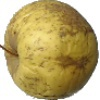

In [23]:
# Affichage d'une image
ImageArray_first = ImageSchema.toNDArray(spark_df.first()['image'])[:, :, ::-1]
Image.fromarray(ImageArray_first)

___
## 2. EXTRACTION DES FEATURES

Nous utilisons ici une approche de featurization de nos images par transfer learning.

Cela consiste à extraire les features les plus pertinentes pour la classification de nos iamges en utilisant un modèle de deep learning pré-entraîné sur de la classification d'image, auquel on enlève la dernière couche - celle qui classifie - afin d'obtenir en sortie un tenseur des features les plus significatives de nos images.

Ce tenseur pourra ensuite être fourni à un autre modèle de classification, qui sera ainsi adapté à nos classes.

Nous utilisons ici un modèle VGG16 pré-entraîné pour de la classification d'images, auquel nous retirons la dernière couche.

In [24]:
# modèle
conv_base = VGG16(
    include_top=False,
    weights=None,
    pooling='max',
    input_shape=(100, 100, 3))

In [25]:
# vérifie que la couche supérieure est supprimée
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [26]:
conv_base_weights = spark.sparkContext.broadcast(conv_base.get_weights())

In [27]:
def conv_base_init():
    '''
        Renvoie un modèle VGG 16 avec la couche supérieure supprimée et les poids diffusés
    '''
    conv_base = VGG16(
        include_top=False,
        weights=None,
        pooling='max',
        input_shape=(100, 100, 3))
    conv_base.set_weights(conv_base_weights.value)
    return conv_base

#------------------------------------------------------------------------

# function to get tensors from batch path
def gettensorfrompath(image_path):
    path = image_path.replace("file:///", "")
    img = load_img(path)
    x = img_to_array(img)
    x = preprocess_input(x)
    return x

#------------------------------------------------------------------------

@pandas_udf('array<double>')
def featurize(images_data_iter: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    '''
        Fonction utilisateur d'extraction des features
    '''
    conv_base = conv_base_init()
    for image_data_series in images_data_iter:
        image_path_series = image_data_series['origin']
        x = image_path_series.map(gettensorfrompath)
        x = np.stack(list(x.values))
        features = conv_base.predict(x)
        features_flat = [p.flatten() for p in features]
        yield pd.Series(features_flat)

#------------------------------------------------------------------------


In [28]:
# Applique l'extraction des features

start = time.perf_counter()
featurized_df = spark_df.withColumn('cnn_features', featurize('image')).cache()
stop = time.perf_counter()
print(f'Temps extraction des features: {stop - start:0.2f} secondes')

Temps extraction des features: 0.24 secondes


In [29]:
featurized_df.show()

+--------------------+--------------------+--------------+--------------------+
|               image|                path|      category|        cnn_features|
+--------------------+--------------------+--------------+--------------------+
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.30993726849555...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.33944892883300...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.35247966647148...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.37810212373733...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.36986348032951...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.33523747324943...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.36603018641471...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.38245406746864...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.35272663831710...|
|{file:///C:/Users...|file:///C:/Users/.

___
## 3. REDUCTION DE DIMENION (PCA)

In [30]:
# De Array à Vectors pour appliquer la PCA
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [31]:
vectorized_df = featurized_df.withColumn('cnn_vectors', array_to_vector_udf('cnn_features'))

In [32]:
vectorized_df.show(5, True)

+--------------------+--------------------+--------------+--------------------+--------------------+
|               image|                path|      category|        cnn_features|         cnn_vectors|
+--------------------+--------------------+--------------+--------------------+--------------------+
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.30993726849555...|[0.30993726849555...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.33944892883300...|[0.33944892883300...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.35247966647148...|[0.35247966647148...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.37810212373733...|[0.37810212373733...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.36986348032951...|[0.36986348032951...|
+--------------------+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows



In [33]:
# reduce with PCA - set k Max to determine the adequate nb of principal components
start = time.perf_counter()
pca = PCA(k=20, inputCol='cnn_vectors', outputCol='pca_vectors')
model = pca.fit(vectorized_df)
stop = time.perf_counter()
print(f'Temps de fit de la PCA: {stop - start:0.2f} secondes')

Temps de fit de la PCA: 460.82 secondes


In [34]:
# Applique la réduction de dimension avec PCA

start = time.perf_counter()
reduced_df = model.transform(vectorized_df)
stop = time.perf_counter()
print(f'Temps du transform de la PCA: {stop - start:0.2f} secondes')

Temps du transform de la PCA: 0.40 secondes


In [35]:
reduced_df.show(5, True)

+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
|               image|                path|      category|        cnn_features|         cnn_vectors|         pca_vectors|
+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.30993726849555...|[0.30993726849555...|[-8.1628317972495...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.33944892883300...|[0.33944892883300...|[-8.1283261351403...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.35247966647148...|[0.35247966647148...|[-7.8566129406495...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.37810212373733...|[0.37810212373733...|[-8.2219664201651...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.36986348032951...|[0.36986348032951...|[-8.2050925425347...|
+--------------------+--

In [36]:
# Transformation inverse (de Vectors à Arrays)
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [37]:
final_df = reduced_df.withColumn('features', vector_to_array_udf('pca_vectors'))

In [38]:
final_df.show(5, True)

+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|               image|                path|      category|        cnn_features|         cnn_vectors|         pca_vectors|            features|
+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.30993726849555...|[0.30993726849555...|[-8.1628317972495...|[-8.162832, -0.80...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.33944892883300...|[0.33944892883300...|[-8.1283261351403...|[-8.128326, -0.73...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.35247966647148...|[0.35247966647148...|[-7.8566129406495...|[-7.856613, -0.81...|
|{file:///C:/Users...|file:///C:/Users/...|apple_golden_1|[0.37810212373733...|[0.37810212373733...|[-8.2219664201651...|[-8.221967, -0.72...|

___
## 4. SAUVEGARDE 

In [39]:
# Enregistrement des données (format parquet)

start = time.perf_counter()
final_df.write.mode('overwrite').parquet('./outputs/featurized_sample')
stop = time.perf_counter()
print(f'write local, elapsed time: {stop - start:0.2f}s')

write local, elapsed time: 113.98s


In [40]:
# lecture des données enregistrées (format parquet)

start = time.perf_counter()
pd_final_df = pd.read_parquet('./outputs/featurized_sample', engine='pyarrow')
stop = time.perf_counter()
print(f'read local, elapsed time: {stop - start:0.2f}s')

read local, elapsed time: 0.53s


In [41]:
# Taille du dataframe resultat
pd_final_df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Columns: 7 entries, image to features
dtypes: object(7)
memory usage: 2.3 MB


In [42]:
# Apperçu
pd_final_df.head(5)

,image,path,category,cnn_features,cnn_vectors,pca_vectors,features
0,{'origin': 'file:///C:/Users/RaissaTomeba/Form...,file:///C:/Users/RaissaTomeba/Formation/Projet...,apple_golden_1,"[0.3099372684955597, 0.17139598727226257, 0.50...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.162832, -0.8022361, 0.89716005, -1.348667,..."
1,{'origin': 'file:///C:/Users/RaissaTomeba/Form...,file:///C:/Users/RaissaTomeba/Formation/Projet...,apple_golden_1,"[0.3394489288330078, 0.12721893191337585, 0.50...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.128326, -0.73030764, 0.7424568, -1.3828069..."
2,{'origin': 'file:///C:/Users/RaissaTomeba/Form...,file:///C:/Users/RaissaTomeba/Formation/Projet...,apple_golden_1,"[0.3524796664714813, 0.23455829918384552, 0.42...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-7.856613, -0.8123534, 0.7189054, -1.4763527,..."
3,{'origin': 'file:///C:/Users/RaissaTomeba/Form...,file:///C:/Users/RaissaTomeba/Formation/Projet...,apple_golden_1,"[0.3781021237373352, 0.16101911664009094, 0.51...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.221967, -0.7232069, 0.79988813, -1.3744985..."
4,{'origin': 'file:///C:/Users/RaissaTomeba/Form...,file:///C:/Users/RaissaTomeba/Formation/Projet...,apple_golden_1,"[0.36986348032951355, 0.1845710426568985, 0.54...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.205092, -0.6838171, 0.8058571, -1.3829671,..."


In [43]:
spark.stop()